In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
torch.set_default_dtype(torch.float32)

## Load data

In [2]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

In [102]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

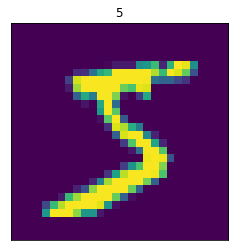

In [103]:
plt.imshow(trainset[0][0].reshape((28, 28)));
plt.title(trainset[0][1]);
plt.xticks([])
plt.yticks([]);

## Prepare a single network module

In [104]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100]):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x):
        out = x
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out

In [6]:
def train_net(net, optimizer, epochs, verbose=False):
    for epoch in range(epochs): 
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            if i % 100 == 0:    # print every 2000 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f acc: %.3f%%' %
                          (epoch + 1, i, running_loss / 100, correct/total*100))
                running_loss = 0.0
                correct = 0
                total=0

        correct = 0
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        print(f"Test acc: {correct/len(testset)*100}")

### Benchmark

#### Full network

In [7]:
net = SimpleNetwork(784)

In [8]:
criterion = torch.nn.CrossEntropyLoss()

In [9]:
%%time
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3)
train_net(net, optimizer, 5)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
train_net(net, optimizer, 5)

Test acc: 96.28999999999999
Test acc: 96.64
Test acc: 97.1
Test acc: 96.5
Test acc: 96.54
Test acc: 97.94
Test acc: 97.98
Test acc: 98.00999999999999
Test acc: 97.84
Test acc: 97.98
CPU times: user 7min 14s, sys: 6.09 s, total: 7min 20s
Wall time: 2min 14s


#### Masked input

In [144]:
class MaskedNetwork(SimpleNetwork):
    def __init__(self, input_size, mask_size, layers=[10]):
        super().__init__(mask_size, layers=layers)
        template = np.zeros(input_size)
        mask = np.random.choice(len(template), mask_size, False)
        template[mask] = 1
        self.mask = torch.from_numpy(template).to(torch.bool)
        
    def forward(self, x):
        data = x[:, self.mask]
        return super().forward(data)

masked_net = MaskedNetwork(784, 20)
optimizer = torch.optim.Adam(masked_net.parameters(), lr=3e-3)
train_net(masked_net, optimizer, 5)
optimizer = torch.optim.Adam(masked_net.parameters(), lr=3e-4)
train_net(masked_net, optimizer, 5)

Test acc: 41.730000000000004
Test acc: 42.33
Test acc: 42.44
Test acc: 43.82


KeyboardInterrupt: 

## Create simple network with insertable weights

In [10]:
flat_parameters = []
for layer in net.parameters():
    flat_parameters.extend(torch.flatten(layer).detach().numpy())
    
flat_parameters = torch.from_numpy(np.array(flat_parameters))

In [11]:
class InsertableNet(SimpleNetwork):
    def __init__(self, weights, inp_size, layers=[100]):
        super().__init__(inp_size, layers)
        with torch.no_grad():
            input_w_size = inp_size*layers[0]
            input_b_size = layers[0]
            
            hidden_w_size = layers[0]*10
            hidden_b_size = 10
            
            inp_weights = weights[:input_w_size].reshape((layers[0], inp_size))
            inp_bias = weights[input_w_size:input_w_size+input_b_size]
            
            output_weights = weights[input_w_size+input_b_size:input_w_size+input_b_size+hidden_w_size].reshape((10, layers[0]))
            output_bias = weights[input_w_size+input_b_size+hidden_w_size:input_w_size+input_b_size+hidden_w_size+hidden_b_size]
            
            self.inp.weight.copy_(inp_weights)
            self.inp.bias.copy_(inp_bias)        
            self.output.weight.copy_(output_weights)
            self.output.bias.copy_(output_bias)        

In [12]:
insert_net = InsertableNet(flat_parameters, 784)

In [13]:
correct = 0
for data in testloader:
    images, labels = data
    outputs = insert_net(images)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
print(f"Test acc: {correct/len(testset)*100}")

Test acc: 97.98


## Create hypernet structure

In [186]:
class Hypernetwork(torch.nn.Module):
    def __init__(self, inp_size=784, mask_size=20, node_hidden_size=20):
        super().__init__()
        self.mask_size = mask_size
        self.input_size = inp_size
        self.node_hidden_size = node_hidden_size
        
        input_w_size = mask_size*node_hidden_size
        input_b_size = node_hidden_size

        hidden_w_size = node_hidden_size*10
        hidden_b_size = 10
            
        self.out_size = input_w_size+input_b_size+hidden_w_size+hidden_b_size
        
        self.input = torch.nn.Linear(inp_size, 256)
        self.hidden = torch.nn.Linear(256, 512)
        self.out = torch.nn.Linear(512, self.out_size)
        
        self.relu = torch.nn.ReLU()
        self.template = np.zeros(inp_size)
        
    
    def forward(self, data, mask=None):
        if mask is None:
            mask = np.random.choice(len(template), self.mask_size, False)
            tmp = self.template.copy()
            tmp[mask] = 1
            mask = torch.from_numpy(tmp).to(torch.float32)
        
        weights = self.craft_network(mask)
        nn = InsertableNet(weights, self.mask_size, layers=[self.node_hidden_size])
#         masked_data = torch.gather(data, dim=1, index=mask.to(torch.int64))
        masked_data = data[:, mask.to(torch.bool)]
        return nn(masked_data)
        
    def craft_network(self, mask):
        out = self.input(mask)
        out = self.relu(out)
        out = self.hidden(out)
        out = self.relu(out)
        out = self.out(out)
        return out

In [187]:
from torchsummary import summary

In [192]:
hypernet = Hypernetwork(mask_size=20)

In [193]:
summary(hypernet, (784, ), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                       [-1]         200,960
              ReLU-2                       [-1]               0
            Linear-3                       [-1]         131,584
              ReLU-4                       [-1]               0
            Linear-5                       [-1]         323,190
Total params: 655,734
Trainable params: 655,734
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 2.50
Estimated Total Size (MB): 2.50
----------------------------------------------------------------


In [ ]:
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-5)
train_net(hypernet, optimizer, 5, verbose=True)

[1,     0] loss: 0.023 acc: 14.062%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36e045d790>
Traceback (most recent call last):
  File "/home/ginterhauser/miniconda3/envs/image_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/ginterhauser/miniconda3/envs/image_processing/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/ginterhauser/miniconda3/envs/image_processing/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[1,   100] loss: 2.302 acc: 12.375%
[1,   200] loss: 2.302 acc: 11.719%
[1,   300] loss: 2.302 acc: 11.938%
[1,   400] loss: 2.302 acc: 11.438%
[1,   500] loss: 2.302 acc: 11.484%
[1,   600] loss: 2.303 acc: 11.625%
[1,   700] loss: 2.302 acc: 10.734%


In [125]:
len(mask)

20

In [126]:
template = np.zeros_like(images[0])

In [140]:
template[mask]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)